In [4]:
import sqlite3
import pandas as pd
import numpy as np

# Veritabanı dosya yolu
DB_PATH = r"C:\Users\emre\Desktop\borsa\bist_all.db"

def load_and_preprocess_full_data():
    print("1. Veritabanına bağlanılıyor...")
    conn = sqlite3.connect(DB_PATH)

    # "SELECT *" diyerek tabloda ne var ne yoksa hepsini çekiyoruz.
    # Filtrelemeyi Pandas tarafında yapacağız, böylece hiçbir sütunu gözden kaçırmayız.
    df = pd.read_sql("SELECT * FROM prices", conn)
    conn.close()

    print(f"   -> Toplam {len(df)} satır, {len(df.columns)} sütun veri çekildi.")

    # 2. İSTEMEDİĞİN SÜTUNLARI AT (DROP)
    unwanted_cols = ['DD_TARIH', 'DD_DOVIZ_KODU', 'SERMAYE']

    # errors='ignore': Eğer sütun zaten yoksa hata verme, devam et.
    df = df.drop(columns=unwanted_cols, errors='ignore')
    print(f"   -> Gereksiz sütunlar ({unwanted_cols}) silindi.")

    # 3. İSİMLENDİRME (Daha anlaşılır olması için kritik olanları düzeltelim)
    # Diğer sütunlar (HGDG_AOF, END_DEGER vs.) orijinal ismiyle kalacak.
    rename_map = {
        'HGDG_HACIM': 'volume_try',
        'DOLAR_HACIM': 'volume_usd',
        'DOLAR_BAZLI_FIYAT': 'close_usd',
        'DOLAR_BAZLI_MIN': 'min_usd',
        'DOLAR_BAZLI_MAX': 'max_usd',
        'DOLAR_BAZLI_AOF': 'weighted_average_usd',
        'PD': 'market_cap_try',
        'PD_USD': 'market_cap_usd',
        'ENDEKS_BAZLI_FIYAT': 'relative_to_index', # Endekse göre performansı
        'END_DEGER' : 'BIST',
        'HAO_PD': 'market_cap_tl_halka_acik',
        'HAO_PD_USD': 'market_cap_usd_halka_acik',
        'HGDG_AOF': 'weighted_average_try',
        'DD_DEGER' : 'usd_kur_price'
    }
    df = df.rename(columns=rename_map)

    # 4. TARİH VE SIRALAMA
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['symbol', 'date']).reset_index(drop=True)

    # 5. VERİ TİPİ DÖNÜŞÜMÜ (Hepsi Sayısal Olmalı)
    # Symbol ve Date hariç her şeyi sayısal (float) yapmaya zorluyoruz.
    # "None", "NULL" gibi değerler NaN (Not a Number) olacak.
    cols_to_exclude = ['symbol', 'date']
    numeric_cols = [c for c in df.columns if c not in cols_to_exclude]

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # # 6. EKSİK VERİ TEMİZLİĞİ (NaN Handling)
    # # İndikatörlerin (SMA_200 vb.) hesaplanamadığı ilk satırları siliyoruz.
    # # Modelin kafası karışmasın diye tam dolu satırlarla çalışmalıyız.
    # print("2. Eksik veriler (NaN) temizleniyor...")
    # original_len = len(df)
    # df = df.dropna()
    # final_len = len(df)
    #
    # print(f"   -> Temizlik sonucu {original_len - final_len} satır silindi.")
    print(f"   -> MODEL İÇİN HAZIR SATIR SAYISI: {len(df)}")
    print(f"   -> SÜTUN SAYISI: {len(df.columns)}")

    return df

# --- KODU ÇALIŞTIR ---
if __name__ == "__main__":
    df_final = load_and_preprocess_full_data()

    print("\n--- SÜTUN LİSTESİ (HEPSİ BURADA MI?) ---")
    print(list(df_final.columns))

    print("\n--- VERİ ÖRNEĞİ ---")
    pd.set_option('display.max_columns', None)


1. Veritabanına bağlanılıyor...
   -> Toplam 2170695 satır, 35 sütun veri çekildi.
   -> Gereksiz sütunlar (['DD_TARIH', 'DD_DOVIZ_KODU', 'SERMAYE']) silindi.
   -> MODEL İÇİN HAZIR SATIR SAYISI: 2170695
   -> SÜTUN SAYISI: 32

--- SÜTUN LİSTESİ (HEPSİ BURADA MI?) ---
['symbol', 'date', 'close', 'weighted_average_try', 'low', 'high', 'volume_try', 'BIST', 'usd_kur_price', 'close_usd', 'relative_to_index', 'volume_usd', 'market_cap_try', 'market_cap_usd', 'market_cap_tl_halka_acik', 'market_cap_usd_halka_acik', 'volume', 'min_usd', 'max_usd', 'weighted_average_usd', 'pct_change', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_50', 'SMA_200', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0']

--- VERİ ÖRNEĞİ ---


In [5]:
df_final.head()

,symbol,date,close,weighted_average_try,low,high,volume_try,BIST,usd_kur_price,close_usd,relative_to_index,volume_usd,market_cap_try,market_cap_usd,market_cap_tl_halka_acik,market_cap_usd_halka_acik,volume,min_usd,max_usd,weighted_average_usd,pct_change,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_50,SMA_200,BBL_20_2.0_2.0,BBM_20_2.0_2.0,BBU_20_2.0_2.0,BBB_20_2.0_2.0,BBP_20_2.0_2.0
0,A1CAP,2023-06-15,5.500,5.5000,5.500,5.500,7210885.0,5495.48,23.6815,0.2322,0.0010,3.044944e+05,3.712500e+09,1.567679e+08,NaN,NaN,7210885.0,0.2322,0.2322,0.2322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A1CAP,2023-06-16,6.048,6.0480,6.048,6.048,35365650.0,5475.48,23.6814,0.2554,0.0011,1.493394e+06,4.082400e+09,1.723885e+08,1.058158e+09,4.468309e+07,35365650.0,0.2554,0.2554,0.2554,0.099636,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A1CAP,2023-06-19,6.652,6.6520,6.652,6.652,72099398.0,5269.31,23.6797,0.2809,0.0013,3.044777e+06,4.490100e+09,1.896181e+08,1.163834e+09,4.914901e+07,72099398.0,0.2809,0.2809,0.2809,0.099868,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A1CAP,2023-06-20,5.988,6.0646,5.988,6.220,244534533.0,5251.61,23.6194,0.2535,0.0011,1.035312e+07,4.041900e+09,1.711263e+08,1.047660e+09,4.435593e+07,244534533.0,0.2535,0.2633,0.2568,-0.099820,91.530612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A1CAP,2023-06-21,5.392,5.3920,5.392,5.392,57894308.0,5186.83,23.5917,0.2286,0.0010,2.454012e+06,3.639600e+09,1.542746e+08,9.433843e+08,3.998797e+07,57894308.0,0.2286,0.2286,0.2286,-0.099532,84.604223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# df_final oluşturulduktan sonra bu satırları ekle:

# 1. En eski tarihi bul
en_eski_tarih = df_final['date'].min()
print(f"Verisetindeki En Eski Tarih: {en_eski_tarih}")

# 2. O tarihe sahip tüm satırları getir (Birden fazla hisse olabilir)
en_eski_satirlar = df_final[df_final['date'] == en_eski_tarih]

print("\n--- EN ESKİ TARİHLİ SATIRLAR ---")
# Tüm sütunları görmek için ayar
pd.set_option('display.max_columns', None)
print(en_eski_satirlar)

Verisetindeki En Eski Tarih: 1996-12-26 00:00:00

--- EN ESKİ TARİHLİ SATIRLAR ---
        symbol       date   close  weighted_average_try       low      high  \
5052      ADEL 1996-12-26  0.0024              0.002315  0.002293  0.002362   
46414    AKBNK 1996-12-26  0.0274              0.026595  0.026019  0.027365   
53615    AKCNS 1996-12-26  0.0443              0.043696  0.042996  0.044751   
71690    AKGRT 1996-12-26  0.0007              0.000663  0.000659  0.000681   
84060     AKSA 1996-12-26  0.0035              0.003474  0.003396  0.003572   
...        ...        ...     ...                   ...       ...       ...   
2077338  VKFYO 1996-12-26  0.0131              0.013199  0.012649  0.013521   
2091728  VKING 1996-12-26  0.5134              0.512930  0.503507  0.523253   
2103285  YATAS 1996-12-26  0.0713              0.071052  0.070210  0.072370   
2132851  YKBNK 1996-12-26  0.0162              0.016150  0.015609  0.016509   
2144236  YUNSA 1996-12-26  0.0052              0

In [1]:
!pip install seaborn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


1. Veritabanına bağlanılıyor...

--- VERİ ÖZETİ ---


C:\Users\emre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


                  count          mean            std          min         25%  \
close      2170687.0000     1930.9267     96220.3706 -163823.7344      0.3319   
pct_change 2169978.0000           inf            NaN      -1.0047     -0.0146   
volume_try 2170684.0000 67529031.8073 401583277.4904       0.0000 227668.7500   
close_usd  2170687.0000       78.4122      3553.0471 -653618.5687      0.1298   

                    50%           75%              max  
close            1.2800        6.4500     8930892.0000  
pct_change       0.0000        0.0148              inf  
volume_try 1877194.5000 19026404.5000 29030652129.0000  
close_usd        0.3701        1.0313      315802.4045  

--- DAĞILIM ANALİZİ ---


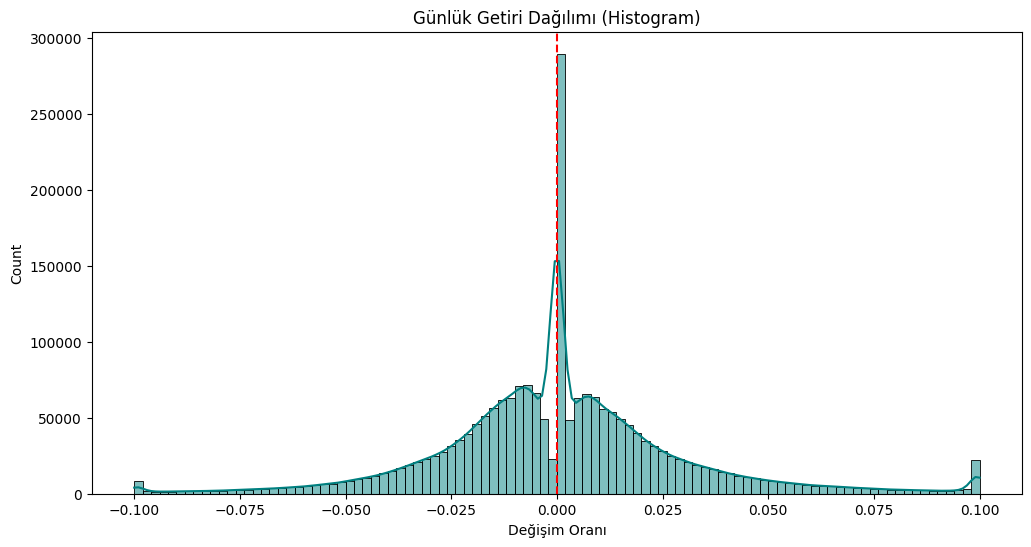

Ortalama Günlük Getiri: 0.00075
Standart Sapma: 0.02974

--- KORELASYON ANALİZİ ---
Hissenin Yükselmesiyle (pct_change) En Çok İlişkili Olanlar:
pct_change                 1.0000
RSI_14                     0.0183
BBB_20_2.0_2.0             0.0053
market_cap_tl_halka_acik   0.0028
volume_usd                 0.0017
volume_try                 0.0011
volume                     0.0011
close_usd                  0.0004
MACDh_12_26_9              0.0002
MACD_12_26_9               0.0001
Name: pct_change, dtype: float64


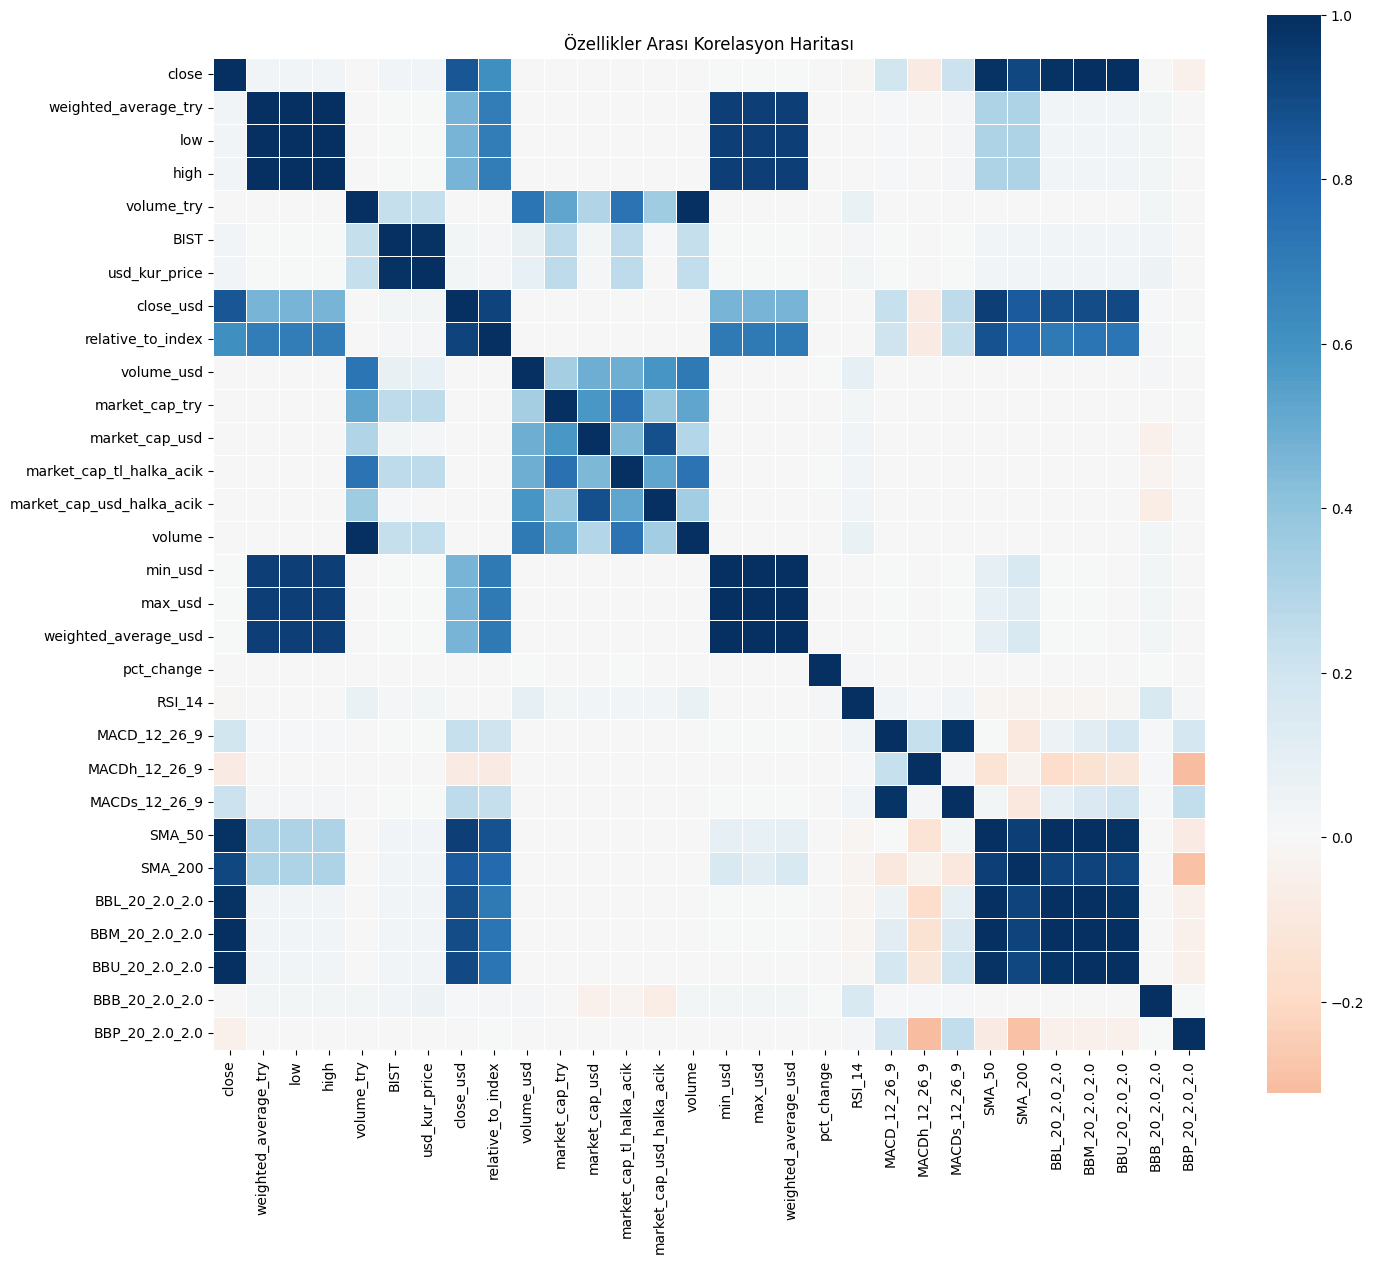


--- THYAO GRAFİK KONTROLÜ ---


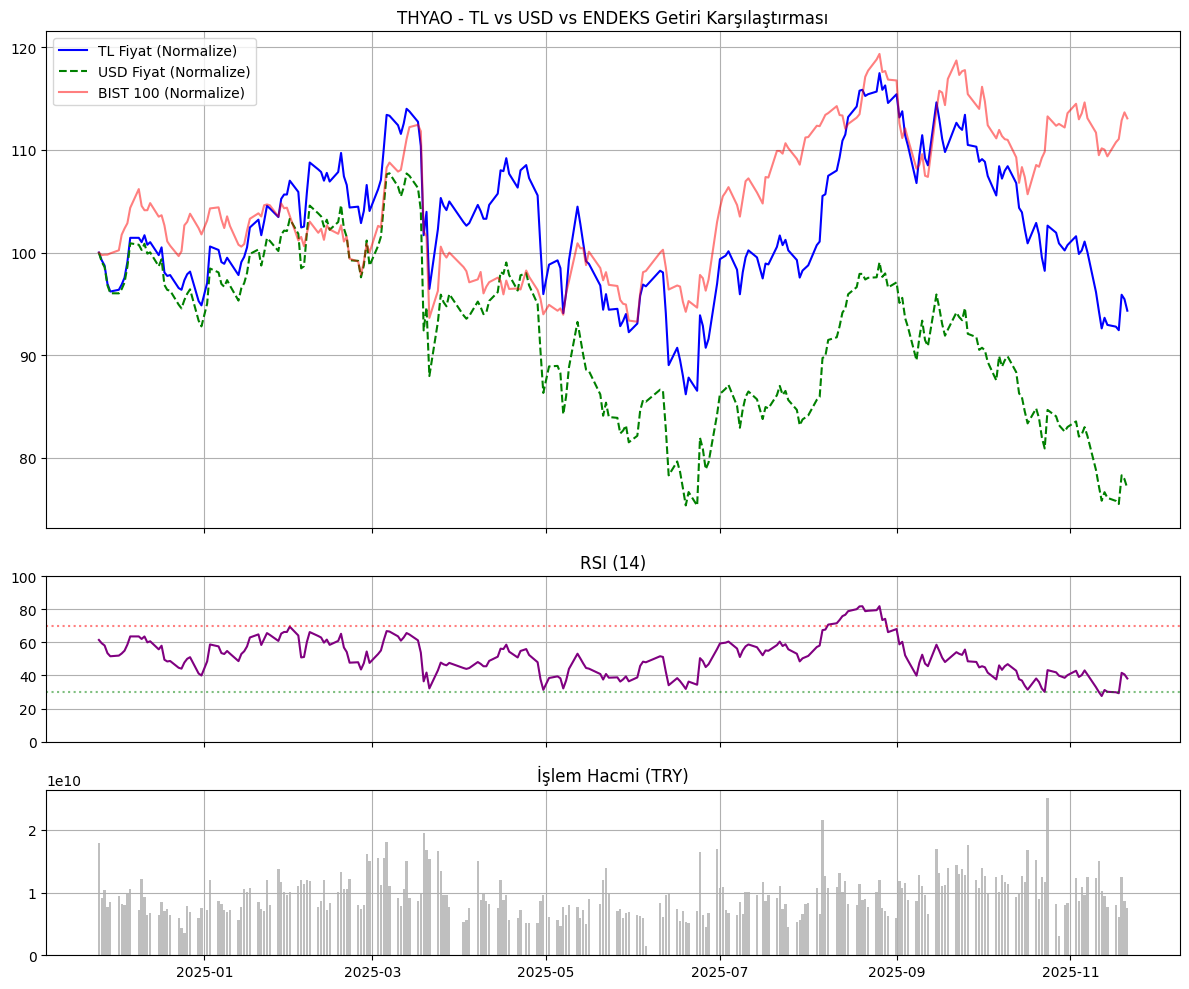

In [8]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- SENİN GÜNCEL PREPROCESSING KODUN ---
DB_PATH = r"C:\Users\emre\Desktop\borsa\bist_all.db"

def load_and_preprocess_full_data():
    print("1. Veritabanına bağlanılıyor...")
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql("SELECT * FROM prices", conn)
    conn.close()

    # Gereksizleri at
    unwanted_cols = ['DD_TARIH', 'DD_DOVIZ_KODU', 'SERMAYE']
    df = df.drop(columns=unwanted_cols, errors='ignore')

    # SENİN YENİ İSİMLENDİRMELERİN
    rename_map = {
        'HGDG_HACIM': 'volume_try',
        'DOLAR_HACIM': 'volume_usd',
        'DOLAR_BAZLI_FIYAT': 'close_usd',
        'DOLAR_BAZLI_MIN': 'min_usd',
        'DOLAR_BAZLI_MAX': 'max_usd',
        'DOLAR_BAZLI_AOF': 'weighted_average_usd',
        'PD': 'market_cap_try',
        'PD_USD': 'market_cap_usd',
        'ENDEKS_BAZLI_FIYAT': 'relative_to_index',
        'END_DEGER' : 'BIST',
        'HAO_PD': 'market_cap_tl_halka_acik',
        'HAO_PD_USD': 'market_cap_usd_halka_acik',
        'HGDG_AOF': 'weighted_average_try',
        'DD_DEGER' : 'usd_kur_price'
    }
    df = df.rename(columns=rename_map)

    # Tarih ve Sıralama
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['symbol', 'date']).reset_index(drop=True)

    # Sayısal Dönüşüm
    cols_to_exclude = ['symbol', 'date']
    numeric_cols = [c for c in df.columns if c not in cols_to_exclude]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Not: dropna() kapalı olduğu için analiz fonksiyonlarında
    # .dropna() kullanarak geçici temizlik yapacağız.

    return df

# --- ANALİZ VE GÖRSELLEŞTİRME FONKSİYONLARI ---

def analyze_correlations(df):
    """
    Sütunlar arasındaki ilişkiyi inceler.
    """
    print("\n--- KORELASYON ANALİZİ ---")

    # Sadece sayısal sütunları al
    numeric_df = df.select_dtypes(include=[np.number])

    # Korelasyon hesapla
    corr = numeric_df.corr()

    # pct_change (Getiri) ile en ilişkili 10 özelliği yazdır
    if 'pct_change' in corr.columns:
        print("Hissenin Yükselmesiyle (pct_change) En Çok İlişkili Olanlar:")
        print(corr['pct_change'].sort_values(ascending=False).head(10))
    else:
        print("Uyarı: 'pct_change' sütunu bulunamadı.")

    # Görselleştirme (Heatmap)
    plt.figure(figsize=(16, 14))
    # annot=True yaparsak kutuların içinde sayılar da yazar (kalabalık olabilir)
    sns.heatmap(corr, cmap='RdBu', center=0, annot=False, square=True, linewidths=.5)
    plt.title('Özellikler Arası Korelasyon Haritası')
    plt.show()

def analyze_distribution(df):
    """
    Verinin dağılımını kontrol eder.
    """
    print("\n--- DAĞILIM ANALİZİ ---")

    plt.figure(figsize=(12, 6))

    # pct_change içindeki NaN'ları temizle ve uç değerleri filtrele
    subset = df['pct_change'].dropna()
    subset = subset[(subset > -0.10) & (subset < 0.10)]

    sns.histplot(subset, bins=100, kde=True, color='teal')
    plt.title('Günlük Getiri Dağılımı (Histogram)')
    plt.xlabel('Değişim Oranı')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

    print(f"Ortalama Günlük Getiri: {subset.mean():.5f}")
    print(f"Standart Sapma: {subset.std():.5f}")

def check_single_stock(df, symbol_to_check="THYAO"):
    """
    Spesifik bir hissenin grafiğini çizer (TL vs USD ve Hacim).
    """
    print(f"\n--- {symbol_to_check} GRAFİK KONTROLÜ ---")

    # Hissenin verisini al ve kopyasını oluştur (orijinal df bozulmasın)
    stock_data = df[df['symbol'] == symbol_to_check].copy()

    if stock_data.empty:
        print("Hisse bulunamadı, verisetindeki ilk hisse seçiliyor...")
        symbol_to_check = df['symbol'].iloc[0]
        stock_data = df[df['symbol'] == symbol_to_check].copy()

    # Grafik için NaN olan satırları atıyoruz (Senin verinde başta boşluklar olabilir)
    stock_data = stock_data.dropna(subset=['close', 'close_usd', 'volume_try'])

    # Son 1 yılı (yaklaşık 250 işlem günü) çizelim
    stock_data = stock_data.tail(250)

    fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

    # 1. Fiyat Grafiği (TL ve USD Karşılaştırmalı - Normalize edilmiş)
    # İkisini aynı eksende görebilmek için normalize ediyoruz (Başlangıç=100)
    start_tl = stock_data['close'].iloc[0]
    start_usd = stock_data['close_usd'].iloc[0]

    norm_tl = stock_data['close'] / start_tl * 100
    norm_usd = stock_data['close_usd'] / start_usd * 100

    ax[0].plot(stock_data['date'], norm_tl, label='TL Fiyat (Normalize)', color='blue')
    ax[0].plot(stock_data['date'], norm_usd, label='USD Fiyat (Normalize)', color='green', linestyle='--')

    # BIST endeksini de normalize edip ekleyelim (Eğer varsa)
    if 'BIST' in stock_data.columns and not stock_data['BIST'].isna().all():
         start_bist = stock_data['BIST'].iloc[0]
         norm_bist = stock_data['BIST'] / start_bist * 100
         ax[0].plot(stock_data['date'], norm_bist, label='BIST 100 (Normalize)', color='red', alpha=0.5)

    ax[0].set_title(f'{symbol_to_check} - TL vs USD vs ENDEKS Getiri Karşılaştırması')
    ax[0].legend()
    ax[0].grid(True)

    # 2. RSI (Eğer varsa)
    if 'RSI_14' in stock_data.columns:
        ax[1].plot(stock_data['date'], stock_data['RSI_14'], color='purple')
        ax[1].axhline(70, color='red', linestyle=':', alpha=0.5)
        ax[1].axhline(30, color='green', linestyle=':', alpha=0.5)
        ax[1].set_title('RSI (14)')
        ax[1].set_ylim(0, 100)
        ax[1].grid(True)

    # 3. Hacim (volume_try - Senin yeni ismin)
    ax[2].bar(stock_data['date'], stock_data['volume_try'], color='gray', alpha=0.5, label='TL Hacim')
    ax[2].set_title('İşlem Hacmi (TRY)')
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()

# --- ANA İŞLEM ---
if __name__ == "__main__":
    # 1. df_final'i oluştur (Senin fonksiyonunla)
    df_final = load_and_preprocess_full_data()

    print("\n--- VERİ ÖZETİ ---")
    # describe() NaN'ları otomatik atlayıp hesaplar, sorun çıkarmaz.
    cols_to_desc = ['close', 'pct_change', 'volume_try', 'close_usd']
    # Sütunlar var mı kontrolü
    existing_cols = [c for c in cols_to_desc if c in df_final.columns]
    print(df_final[existing_cols].describe().T)

    # 2. Görsel Analizleri Başlat
    # Hata almamak için bu fonksiyonlar içinde geçici dropna yapıyoruz.
    analyze_distribution(df_final)
    analyze_correlations(df_final)
    check_single_stock(df_final, "THYAO") # Dilediğin hisseyi yaz

THYAO ve PGSUS verileri çekiliyor...
Ortak Tarih Sayısı: 3150 gün

📊 THYAO - PGSUS İLİŞKİ RAPORU
1. Fiyat Korelasyonu (Trend):  0.9884
   (Not: Enflasyon yüzünden bu genelde yüksek çıkar, yanıltabilir.)
----------------------------------------
2. GETİRİ KORELASYONU (Gerçek): 0.7112
   (Anlamı: THYAO %1 hareket ettiğinde, PGSUS genelde 0.71 katı yönde hareket eder.)


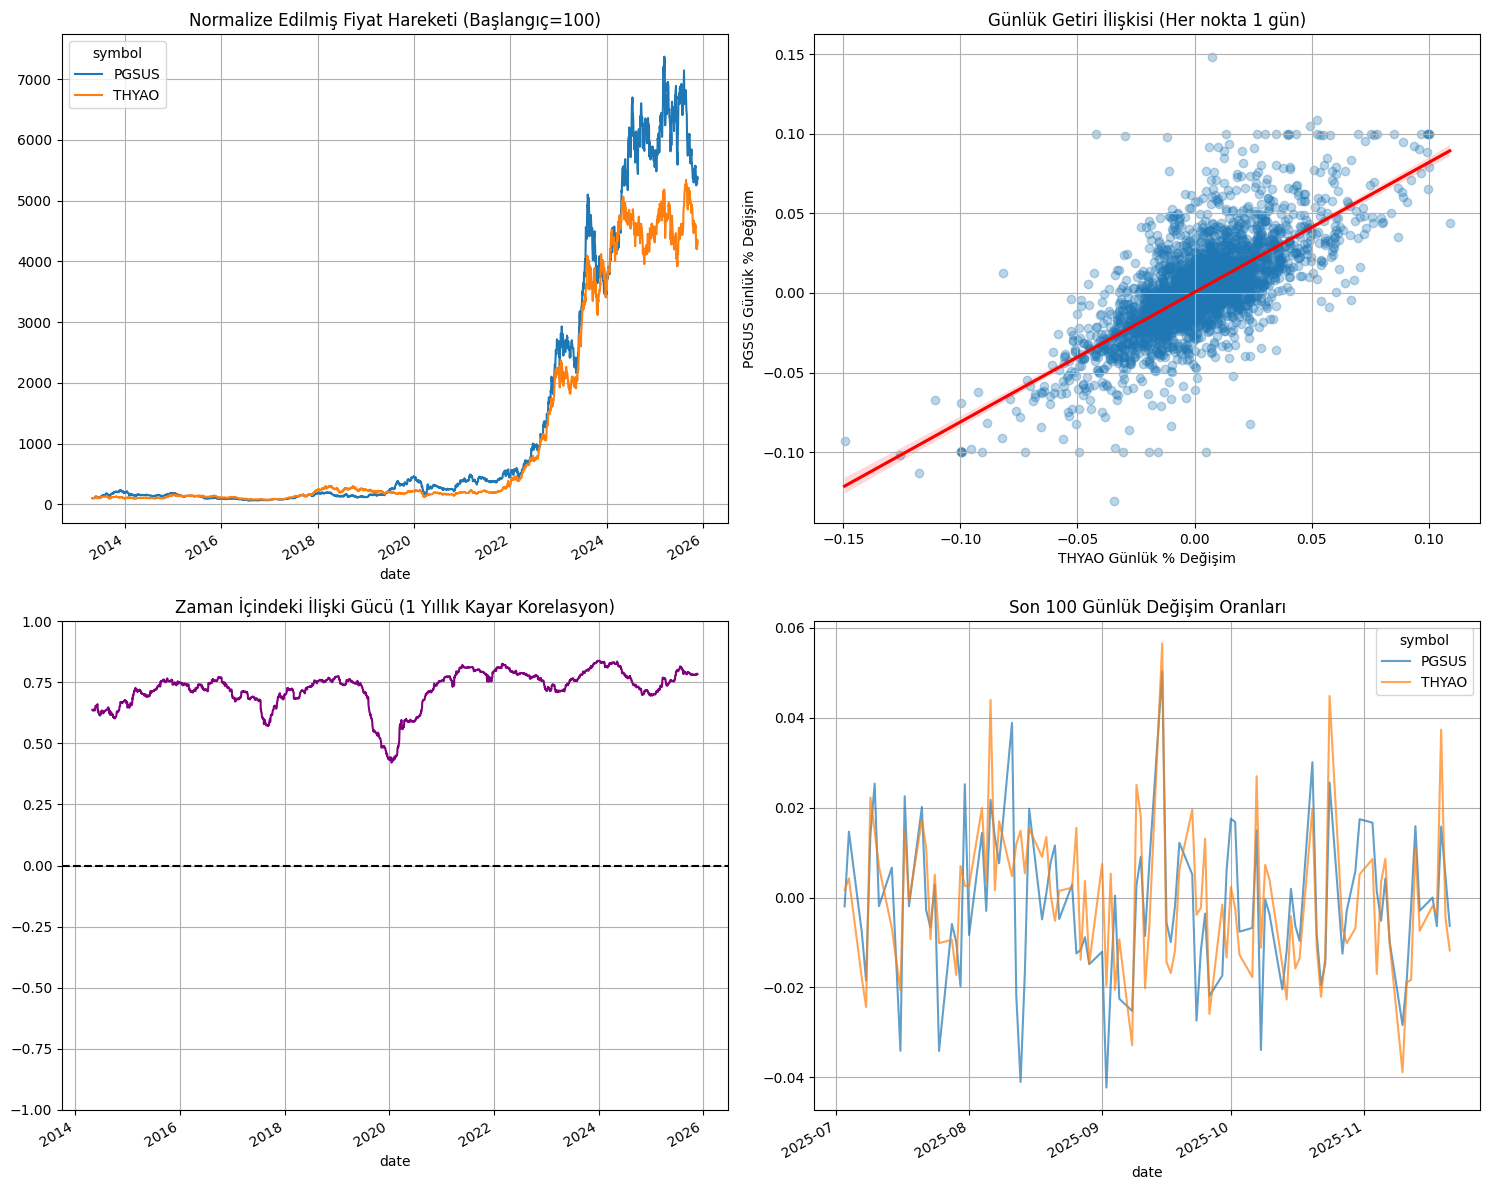

In [11]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Veritabanı yolu
DB_PATH = r"C:\Users\emre\Desktop\borsa\bist_all.db"

def ikili_korelasyon_analizi(symbol1="THYAO", symbol2="PGSUS"):
    print(f"{symbol1} ve {symbol2} verileri çekiliyor...")
    conn = sqlite3.connect(DB_PATH)

    # Sadece bu iki hissenin tarih, kapanış ve değişim oranını çekiyoruz
    query = f"""
    SELECT date, symbol, close, pct_change
    FROM prices
    WHERE symbol IN ('{symbol1}', '{symbol2}')
    """
    df = pd.read_sql(query, conn)
    conn.close()

    # Tarihi formatla
    df['date'] = pd.to_datetime(df['date'])

    # --- VERİ DÖNÜŞÜMÜ (PIVOT) ---
    # Veriyi yan yana getirmemiz lazım:
    # Tarih | THYAO_Close | PGSUS_Close | THYAO_Pct | PGSUS_Pct

    # 1. Kapanış Fiyatları Tablosu
    prices_pivot = df.pivot(index='date', columns='symbol', values='close')

    # 2. Günlük Değişim Tablosu (Asıl önemli olan bu)
    returns_pivot = df.pivot(index='date', columns='symbol', values='pct_change')

    # Eksik verileri at (Biri halka arz olmamışsa o tarihleri sil)
    returns_pivot = returns_pivot.dropna()
    prices_pivot = prices_pivot.dropna()

    print(f"Ortak Tarih Sayısı: {len(returns_pivot)} gün")

    # --- KORELASYON HESABI ---
    corr_getiri = returns_pivot[symbol1].corr(returns_pivot[symbol2])
    corr_fiyat = prices_pivot[symbol1].corr(prices_pivot[symbol2])

    print("\n" + "="*40)
    print(f"📊 {symbol1} - {symbol2} İLİŞKİ RAPORU")
    print("="*40)
    print(f"1. Fiyat Korelasyonu (Trend):  {corr_fiyat:.4f}")
    print(f"   (Not: Enflasyon yüzünden bu genelde yüksek çıkar, yanıltabilir.)")
    print("-" * 40)
    print(f"2. GETİRİ KORELASYONU (Gerçek): {corr_getiri:.4f}")
    print(f"   (Anlamı: {symbol1} %1 hareket ettiğinde, {symbol2} genelde {corr_getiri:.2f} katı yönde hareket eder.)")
    print("="*40)

    # --- GÖRSELLEŞTİRME ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Grafik 1: Fiyatların Zaman İçindeki Hareketi (Normalize)
    # İkisini de 100'den başlatıyoruz ki kıyaslayabilelim
    norm_prices = prices_pivot / prices_pivot.iloc[0] * 100
    norm_prices.plot(ax=axes[0, 0])
    axes[0, 0].set_title('Normalize Edilmiş Fiyat Hareketi (Başlangıç=100)')
    axes[0, 0].grid(True)

    # Grafik 2: Scatter Plot (Saçılım) - Getiri İlişkisi
    sns.regplot(x=returns_pivot[symbol1], y=returns_pivot[symbol2], ax=axes[0, 1],
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    axes[0, 1].set_title(f'Günlük Getiri İlişkisi (Her nokta 1 gün)')
    axes[0, 1].set_xlabel(f'{symbol1} Günlük % Değişim')
    axes[0, 1].set_ylabel(f'{symbol2} Günlük % Değişim')
    axes[0, 1].grid(True)

    # Grafik 3: Kayar Korelasyon (Rolling Correlation) - 1 Yıllık (252 gün)
    # İlişkinin zamanla nasıl değiştiğini gösterir
    rolling_corr = returns_pivot[symbol1].rolling(window=252).corr(returns_pivot[symbol2])
    rolling_corr.plot(ax=axes[1, 0], color='purple')
    axes[1, 0].set_title(f'Zaman İçindeki İlişki Gücü (1 Yıllık Kayar Korelasyon)')
    axes[1, 0].axhline(0, color='black', linestyle='--')
    axes[1, 0].set_ylim(-1, 1)
    axes[1, 0].grid(True)

    # Grafik 4: Son 100 Günlük Hareket
    returns_pivot.tail(100).plot(ax=axes[1, 1], alpha=0.7)
    axes[1, 1].set_title('Son 100 Günlük Değişim Oranları')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    ikili_korelasyon_analizi("THYAO", "PGSUS")

🤖 BOT BAŞLATILIYOR: THYAO referans alınarak PGSUS işlem görecek...


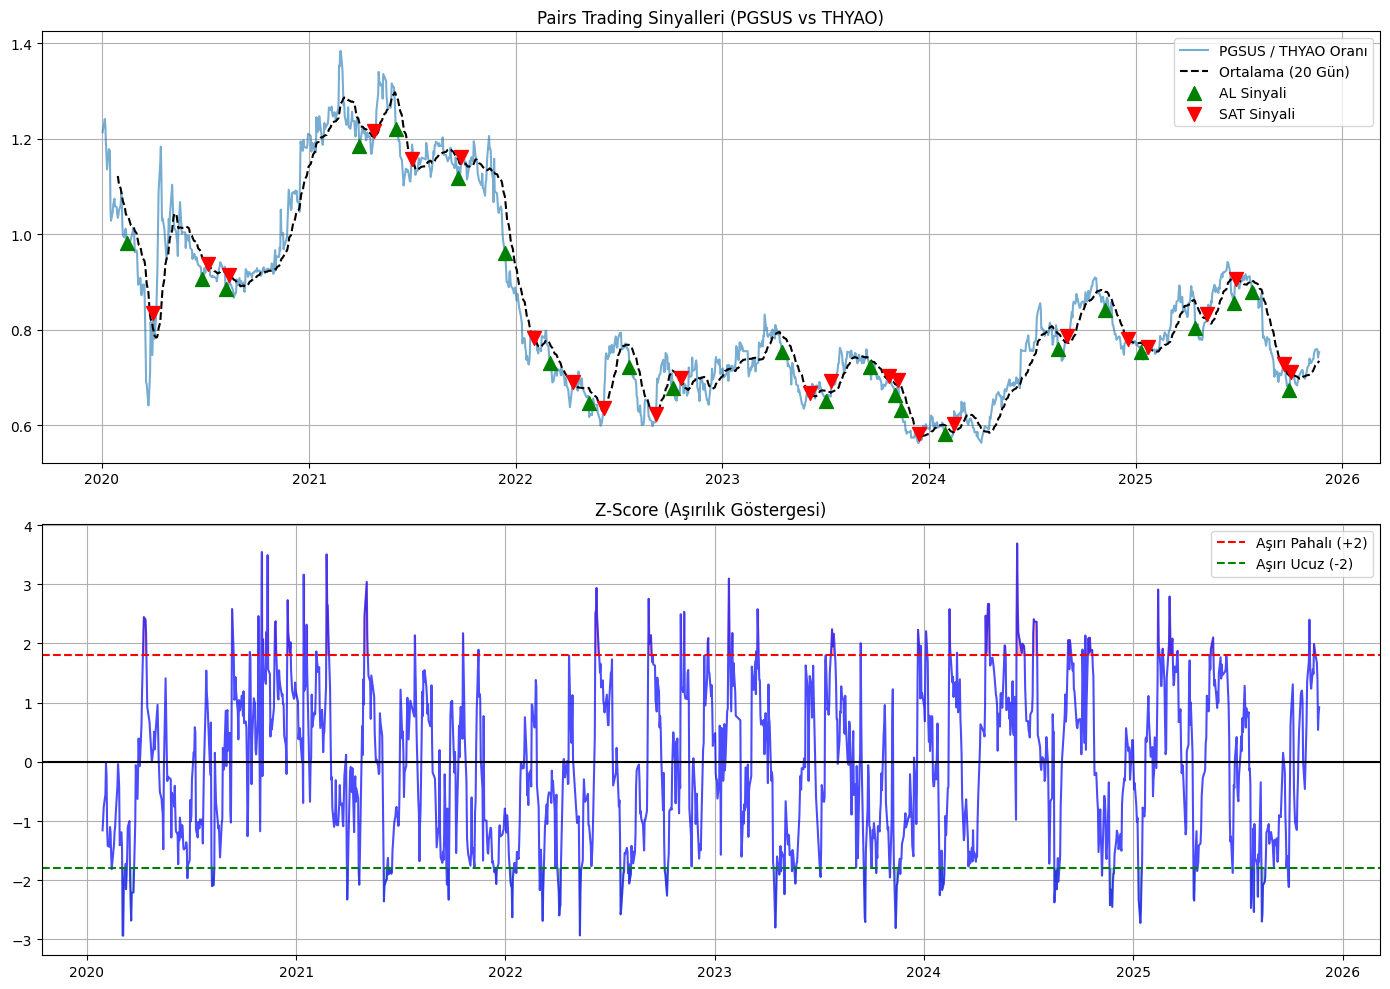


✅ Analiz Tamamlandı.
Toplam Alım Sinyali: 24
Toplam Satış Sinyali: 24
Tahmini Kümülatif Getiri (Basit): %73.58


In [12]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veritabanı yolu
DB_PATH = r"C:\Users\emre\Desktop\borsa\bist_all.db"

def pairs_trading_strategy(symbol1="THYAO", symbol2="PGSUS", window=20, threshold=2.0):
    print(f"🤖 BOT BAŞLATILIYOR: {symbol1} referans alınarak {symbol2} işlem görecek...")

    conn = sqlite3.connect(DB_PATH)
    query = f"""
    SELECT date, symbol, close
    FROM prices
    WHERE symbol IN ('{symbol1}', '{symbol2}') AND date >= '2020-01-01'
    """
    df = pd.read_sql(query, conn)
    conn.close()

    df['date'] = pd.to_datetime(df['date'])

    # Veriyi Pivotla (Yan yana getir)
    data = df.pivot(index='date', columns='symbol', values='close').dropna()

    # --- STRATEJİ HESAPLAMALARI ---

    # 1. Oranı Hesapla (Spread)
    # PGSUS'un THYAO'ya göre değeri
    data['ratio'] = data[symbol2] / data[symbol1]

    # 2. Hareketli Ortalama ve Standart Sapma (Bollinger Mantığı)
    data['mean'] = data['ratio'].rolling(window=window).mean()
    data['std'] = data['ratio'].rolling(window=window).std()

    # 3. Z-Skor Hesapla (Normalden ne kadar saptık?)
    # Formül: (Mevcut Oran - Ortalama) / Standart Sapma
    data['z_score'] = (data['ratio'] - data['mean']) / data['std']

    # --- AL / SAT SİNYALLERİ ---
    data['signal'] = 0

    # Z-Skor -2'nin altındaysa: PGSUS çok ucuz kalmış -> AL (1)
    # Z-Skor +2'nin üstündeyse: PGSUS çok pahalı olmuş -> SAT (-1)
    # Diğer durumlarda bekle (0)

    # Pozisyon Mantığı:
    # AL sinyali gelince alıyoruz, Z-Score 0'a (Normale) dönene kadar taşıyoruz.
    # Bu basit bir simülasyon.

    buy_signals = []
    sell_signals = []
    position = 0 # 0: Yok, 1: Elimde Var

    # Simülasyon Döngüsü
    for i in range(len(data)):
        z = data['z_score'].iloc[i]
        price = data[symbol2].iloc[i] # PGSUS Fiyatı

        # ALIM KOŞULU: Z-Score çok düştüyse (-2 altı) ve elimde yoksa
        if z < -threshold and position == 0:
            buy_signals.append(price)
            sell_signals.append(np.nan)
            position = 1 # Aldım

        # SATIŞ KOŞULU: Z-Score normale döndüyse (0 veya üzeri) veya aşırı şiştiyse ve elimde varsa
        elif z > 0 and position == 1:
            buy_signals.append(np.nan)
            sell_signals.append(price)
            position = 0 # Sattım
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    data['buy_price'] = buy_signals
    data['sell_price'] = sell_signals

    # --- GÖRSELLEŞTİRME ---
    plt.figure(figsize=(14, 10))

    # Grafik 1: Oran ve Sinyaller
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data['ratio'], label=f'{symbol2} / {symbol1} Oranı', alpha=0.6)
    plt.plot(data.index, data['mean'], label='Ortalama (20 Gün)', color='black', linestyle='--')

    # Alım noktalarını Yeşil Üçgen ile göster
    # (Sadece sinyal olan yerleri çizmek için valid indexleri alıyoruz)
    buys = data[data['buy_price'].notnull()]
    sells = data[data['sell_price'].notnull()]

    plt.scatter(buys.index, buys['ratio'], marker='^', color='green', s=100, label='AL Sinyali', zorder=5)
    plt.scatter(sells.index, sells['ratio'], marker='v', color='red', s=100, label='SAT Sinyali', zorder=5)

    plt.title(f'Pairs Trading Sinyalleri ({symbol2} vs {symbol1})')
    plt.legend()
    plt.grid(True)

    # Grafik 2: Z-Score (Osilatör)
    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['z_score'], color='blue', alpha=0.7)
    plt.axhline(0, color='black')
    plt.axhline(threshold, color='red', linestyle='--', label='Aşırı Pahalı (+2)')
    plt.axhline(-threshold, color='green', linestyle='--', label='Aşırı Ucuz (-2)')
    plt.fill_between(data.index, data['z_score'], threshold, where=data['z_score'] > threshold, color='red', alpha=0.3)
    plt.fill_between(data.index, data['z_score'], -threshold, where=data['z_score'] < -threshold, color='green', alpha=0.3)
    plt.title('Z-Score (Aşırılık Göstergesi)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("\n✅ Analiz Tamamlandı.")
    print(f"Toplam Alım Sinyali: {len(buys)}")
    print(f"Toplam Satış Sinyali: {len(sells)}")

    # Basit Getiri Hesabı (Komisyonsuz)
    if len(sells) > 0:
        # Basitçe her işlemden % kaç kar edilmiş toplayalım
        profits = []
        # İşlem eşleştirmesi basit döngüyle
        b_idx = 0
        for s_val in sells['sell_price']:
             if b_idx < len(buys):
                 b_val = buys['buy_price'].iloc[b_idx]
                 kar = (s_val - b_val) / b_val
                 profits.append(kar)
                 b_idx += 1

        total_ret = sum(profits) * 100
        print(f"Tahmini Kümülatif Getiri (Basit): %{total_ret:.2f}")

if __name__ == "__main__":
    # THYAO referans alınarak PGSUS trade edilecek
    pairs_trading_strategy(symbol1="THYAO", symbol2="PGSUS", window=20, threshold=1.8)

In [13]:
import sqlite3
import pandas as pd
import os

# --- AYARLAR ---
SOURCE_DB = r"C:\Users\emre\Desktop\borsa\bist_all.db"       # Kaynak (Ham)
TARGET_DB = r"C:\Users\emre\Desktop\borsa\bist_model_ready.db" # Hedef (Temiz)
TABLE_NAME = "model_data"

def create_clean_database():
    print(f"1. Kaynak veritabanından veri okunuyor: {SOURCE_DB}")
    conn_src = sqlite3.connect(SOURCE_DB)
    df = pd.read_sql("SELECT * FROM prices", conn_src)
    conn_src.close()

    print(f"   -> Ham veri: {len(df)} satır çekildi.")

    # --- 2. PREPROCESSING (TEMİZLİK VE DÜZENLEME) ---

    # A. Gereksizleri At
    unwanted_cols = ['DD_TARIH', 'DD_DOVIZ_KODU', 'SERMAYE']
    df = df.drop(columns=unwanted_cols, errors='ignore')

    # B. İsimlendirmeyi Düzelt (Senin istediğin format)
    rename_map = {
        'HGDG_HACIM': 'volume_try',
        'DOLAR_HACIM': 'volume_usd',
        'DOLAR_BAZLI_FIYAT': 'close_usd',
        'DOLAR_BAZLI_MIN': 'min_usd',
        'DOLAR_BAZLI_MAX': 'max_usd',
        'DOLAR_BAZLI_AOF': 'weighted_average_usd',
        'PD': 'market_cap_try',
        'PD_USD': 'market_cap_usd',
        'ENDEKS_BAZLI_FIYAT': 'relative_to_index',
        'END_DEGER' : 'BIST',
        'HAO_PD': 'market_cap_tl_halka_acik',
        'HAO_PD_USD': 'market_cap_usd_halka_acik',
        'HGDG_AOF': 'weighted_average_try',
        'DD_DEGER' : 'usd_kur_price'
    }
    df = df.rename(columns=rename_map)

    # C. Tarih Formatı ve Sıralama
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['symbol', 'date']).reset_index(drop=True)

    # Tarihi string'e çevir (SQLite datetime tipini sevmez, string saklar)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    # D. Veri Tiplerini Zorla (Sayısal)
    # Symbol ve Date hariç hepsi float olmalı
    cols_exclude = ['symbol', 'date']
    for col in df.columns:
        if col not in cols_exclude:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # E. NaN Temizliği (Makine Öğrenmesi İçin Şart)
    # İndikatörlerin hesaplanamadığı (SMA_200 vb.) ilk satırları atıyoruz.
    print("2. Eksik veriler temizleniyor...")
    before = len(df)

    # Kritik sütunlarda boşluk varsa o satırı sil
    # (Özellikle close, close_usd ve volume_try dolu olmalı)
    df = df.dropna(subset=['close', 'volume_try', 'pct_change'])

    after = len(df)
    print(f"   -> {before - after} satır temizlendi.")

    # --- 3. YENİ VERİTABANINA KAYIT ---

    print(f"3. Hedef veritabanına yazılıyor: {TARGET_DB}")

    # Eğer eski dosya varsa sil (Temiz başlangıç)
    if os.path.exists(TARGET_DB):
        os.remove(TARGET_DB)
        print("   -> Eski dosya silindi, yenisi oluşturuluyor.")

    conn_target = sqlite3.connect(TARGET_DB)

    # DataFrame'i SQL'e yaz
    # index=False: Pandas indexini (0,1,2...) kaydetme
    df.to_sql(TABLE_NAME, conn_target, if_exists='replace', index=False)

    # --- 4. PERFORMANS İÇİN INDEX OLUŞTURMA ---
    # Bu adım model eğitimi sırasında veri çekerken %500 hız kazandırır.
    print("4. İndeksler oluşturuluyor (Hızlandırma)...")
    cursor = conn_target.cursor()

    # Symbol ve Date'e göre hızlı arama indeksi
    cursor.execute(f"CREATE INDEX idx_symbol_date ON {TABLE_NAME} (symbol, date)")
    # Sadece Date'e göre arama indeksi (Örn: 2023 verilerini getir)
    cursor.execute(f"CREATE INDEX idx_date ON {TABLE_NAME} (date)")

    conn_target.commit()
    conn_target.close()

    print("\n✅ İŞLEM BAŞARIYLA TAMAMLANDI!")
    print(f"📂 Yeni Veritabanı: {TARGET_DB}")
    print(f"📊 Tablo Adı: {TABLE_NAME}")
    print(f"🔢 Toplam Satır: {len(df)}")
    print(f"📝 Sütunlar: {list(df.columns)}")

if __name__ == "__main__":
    create_clean_database()

1. Kaynak veritabanından veri okunuyor: C:\Users\emre\Desktop\borsa\bist_all.db
   -> Ham veri: 2170695 satır çekildi.
2. Eksik veriler temizleniyor...
   -> 725 satır temizlendi.
3. Hedef veritabanına yazılıyor: C:\Users\emre\Desktop\borsa\bist_model_ready.db
4. İndeksler oluşturuluyor (Hızlandırma)...

✅ İŞLEM BAŞARIYLA TAMAMLANDI!
📂 Yeni Veritabanı: C:\Users\emre\Desktop\borsa\bist_model_ready.db
📊 Tablo Adı: model_data
🔢 Toplam Satır: 2169970
📝 Sütunlar: ['symbol', 'date', 'close', 'weighted_average_try', 'low', 'high', 'volume_try', 'BIST', 'usd_kur_price', 'close_usd', 'relative_to_index', 'volume_usd', 'market_cap_try', 'market_cap_usd', 'market_cap_tl_halka_acik', 'market_cap_usd_halka_acik', 'volume', 'min_usd', 'max_usd', 'weighted_average_usd', 'pct_change', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_50', 'SMA_200', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0']


In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def intraday_backtest(symbol1="THYAO.IS", symbol2="PGSUS.IS"):
    print("Son 7 günün 1 dakikalık verisi indiriliyor...")

    # yfinance ile son 7 günün 1 dakikalık verisini çekebiliriz
    # period="7d", interval="1m"
    data1 = yf.download(symbol1, period="7d", interval="1m", progress=False)['Close']
    data2 = yf.download(symbol2, period="7d", interval="1m", progress=False)['Close']

    # Verileri birleştir
    df = pd.DataFrame({'s1': data1, 's2': data2}).dropna()

    # --- STRATEJİ (Aynı Mantık, Sadece Pencere Daralıyor) ---
    # Günlükte 20 gün kullanıyorduk.
    # Dakikalıkta 20 dakika (20 bar) veya 60 dakika (1 saat) kullanabilirsin.
    window = 60  # Son 1 saatin ortalamasına göre işlem yap
    threshold = 2.0

    df['ratio'] = df['s2'] / df['s1']
    df['mean'] = df['ratio'].rolling(window=window).mean()
    df['std'] = df['ratio'].rolling(window=window).std()
    df['z_score'] = (df['ratio'] - df['mean']) / df['std']

    # Sinyal Sayısı
    # Z-Score'un -2'yi kestiği (AL) ve +2'yi kestiği (SAT) yerler
    cross_under = df[(df['z_score'] < -threshold) & (df['z_score'].shift(1) > -threshold)]
    cross_over = df[(df['z_score'] > threshold) & (df['z_score'].shift(1) < threshold)]

    print(f"\n--- 1 DAKİKALIK VERİ TEST SONUCU (SON 7 GÜN) ---")
    print(f"İşlenen Bar Sayısı: {len(df)}")
    print(f"Olası AL Fırsatı: {len(cross_under)}")
    print(f"Olası SAT Fırsatı: {len(cross_over)}")

    # Görselleştirme (Son 1 Gün)
    last_day = df.tail(480) # Yaklaşık 1 işlem günü (8 saat * 60 dk)

    plt.figure(figsize=(14, 6))
    plt.plot(last_day.index, last_day['z_score'], label='Z-Score')
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='green', linestyle='--')
    plt.axhline(0, color='black')
    plt.title('Son 1 Günün Dakikalık Z-Score Hareketi')
    plt.show()

if __name__ == "__main__":
    intraday_backtest()

Son 7 günün 1 dakikalık verisi indiriliyor...


C:\Users\emre\AppData\Local\Temp\ipykernel_16772\615234415.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data1 = yf.download(symbol1, period="7d", interval="1m", progress=False)['Close']
C:\Users\emre\AppData\Local\Temp\ipykernel_16772\615234415.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data2 = yf.download(symbol2, period="7d", interval="1m", progress=False)['Close']


ValueError: If using all scalar values, you must pass an index